In [318]:
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [319]:
# Set seed
random_seed = 123
random.seed = random_seed

In [320]:
# Data generation

n = 1000
p = 2
bernoulli_prob = 0.5
mean_0 = 0
sd = 1

def generate_schema_1(mean_1):

    n_of_1 = sum(np.random.binomial(1, bernoulli_prob, size=n))
    n_of_0 = n - n_of_1

    X_1 =np.random.normal(mean_1, sd, size = (n_of_1, p))

    y_1 = np.repeat(1, n_of_1)

    X_0 = np.random.normal(mean_0, sd, size = (n_of_0, p))

    y_0 = np.repeat(0, n_of_0)

    X = np.concatenate((X_1, X_0), axis=0)
    y = np.concatenate((y_1, y_0), axis=0)

    return np.matrix(X), y

def generate_schema_2(mean_1, corr_ro):
    cov_0 = np.matrix([[sd, corr_ro], [corr_ro, sd]])
    cov_1 = np.matrix([[sd, -corr_ro], [-corr_ro, sd]])
    mean_0_tmp = (mean_0, mean_0) 
    mean_1_tmp = (mean_1, mean_1)

    n_of_1 = sum(np.random.binomial(1, bernoulli_prob, size=n))
    n_of_0 = n - n_of_1

    X_1 = np.random.multivariate_normal(mean_1_tmp, cov_1, size = (n_of_1))

    y_1 = np.repeat(1, n_of_1)

    X_0 = np.random.multivariate_normal(mean_0_tmp, cov_0, size = (n_of_0))

    y_0 = np.repeat(0, n_of_0)

    X = np.concatenate((X_1, X_0), axis=0)
    y = np.concatenate((y_1, y_0), axis=0)

    return np.matrix(X), y


In [321]:
class LDA:
    def __init__(self):
        pass

    def fit(self, X, y):
        self.n, self.p = X.shape
        self.c = len(np.unique(y))

        self.corr = np.cov(X.T)
        
        self.priors = np.array([])
        self.means = np.array([]).reshape(0, self.p)

        for k in range(self.c):
            self.means = np.concatenate((
                self.means, 
                np.array([np.array(np.mean(X[y == k, :], axis=0)).flatten()])
                ), 
                axis=0
            )
            self.priors = np.append(self.priors, np.count_nonzero(y == k))
        
        self.priors = self.priors / self.n 
    
    def predict_proba(self, Xtest):
        def _posterior_bayes_rule():
            posterior = np.array([])

            for obs in self.proba_list:
                posterior = np.append(posterior, ((obs[1] * self.priors[1]) / (obs[0] * self.priors[0] + obs[1] * self.priors[1])))
            
            return posterior
        
        self.proba_list = np.empty((0, self.c), int)
        
        for i in range(Xtest.shape[0]):
            proba_i = np.array([]).reshape(0,self.c)
            for k in range(self.c):
                proba_i = np.append(
                        proba_i, 
                        np.array(
                            (
                                (1 / ((2 * np.pi) ** (self.p / 2))) * 
                                (np.linalg.det(self.corr) ** (1/2))
                            ) * 
                            np.exp(
                                -0.5 * 
                                (Xtest[i] - self.means[k]) * 
                                np.linalg.inv(self.corr) * 
                                np.transpose(Xtest[i] - self.means[k])
                            )
                        ).flatten()
                )
            self.proba_list = np.concatenate((self.proba_list, np.array([proba_i])), axis = 0)

        posterior = _posterior_bayes_rule()

        return posterior
    
    def predict(self, Xtest):
        predict_proba = self.predict_proba(Xtest)
        predict_proba[predict_proba > 0.5] = 1
        predict_proba[predict_proba <= 0.5] = 0
        return predict_proba

    def get_params(self):
        return self.mean, self.corr, self.priors

In [322]:
class QDA:
    def __init__(self):
        pass

    def fit(self, X, y):
        self.n, self.p = X.shape
        self.c = len(np.unique(y))

        self.corrs = np.array([]).reshape(0, self.p, self.p)
        self.priors = np.array([])
        self.means = np.array([]).reshape(0, self.p)

        for k in range(self.c): 
            self.corrs = np.concatenate((
                self.corrs,
                np.array([np.cov(X[y == k, :].T)])
                ),
                axis=0
            )
            
            self.means = np.concatenate((
                self.means, 
                np.array([np.array(np.mean(X[y == k, :], axis=0)).flatten()])
                ), 
                axis=0
            )
            self.priors = np.append(self.priors, np.count_nonzero(y == k))
        
        self.priors = self.priors / self.n 
    
    def predict_proba(self, Xtest):
        def _posterior_bayes_rule():
            posterior = np.array([])

            for obs in self.proba_list:
                posterior = np.append(posterior, ((obs[1] * self.priors[1]) / (obs[0] * self.priors[0] + obs[1] * self.priors[1])))
            
            return posterior
        
        self.proba_list = np.empty((0, self.c), int)
        
        for i in range(Xtest.shape[0]):
            proba_i = np.array([]).reshape(0,self.c)
            for k in range(self.c):
                proba_i = np.append(
                        proba_i, 
                        np.array(
                            (
                                (1 / ((2 * np.pi) ** (self.p / 2))) * 
                                (np.linalg.det(self.corrs[k]) ** (1/2))
                            ) * 
                            np.exp(
                                -0.5 * 
                                (Xtest[i] - self.means[k]) * 
                                np.linalg.inv(self.corrs[k]) * 
                                np.transpose(Xtest[i] - self.means[k])
                            )
                        ).flatten()
                )
            self.proba_list = np.concatenate((self.proba_list, np.array([proba_i])), axis = 0)

        posterior = _posterior_bayes_rule()

        return posterior
    
    def predict(self, Xtest):
        predict_proba = self.predict_proba(Xtest)
        predict_proba[predict_proba > 0.5] = 1
        predict_proba[predict_proba <= 0.5] = 0
        return predict_proba

    def get_params(self):
        return self.mean, self.corr, self.priors

In [323]:
class NB:
    def __init__(self):
        pass

    def fit(self, X, y):
        self.n, self.p = X.shape
        self.c = len(np.unique(y))

        self.variances = np.array([]).reshape(0, self.p)
        self.priors = np.array([])
        self.means = np.array([]).reshape(0, self.p)

        for k in range(self.c): 
            self.variances = np.concatenate((
                self.variances, 
                np.array(np.std(X[y == k, :], axis=0))
                ), 
                axis=0          
            )
            
            self.means = np.concatenate((
                self.means, 
                np.array(np.mean(X[y == k, :], axis=0))
                ), 
                axis=0
            )

            self.priors = np.append(self.priors, np.count_nonzero(y == k))



        self.priors = self.priors / self.n 
    
    def predict_proba(self, Xtest):
        def _posterior_bayes_rule():
            posterior = np.array([])

            for obs in self.proba_list:
                posterior = np.append(posterior, ((obs[1] * self.priors[1]) / (obs[0] * self.priors[0] + obs[1] * self.priors[1])))
            
            return posterior
        
        self.proba_list = np.empty((0, self.c), int)
        
        for i in range(Xtest.shape[0]):
            proba_i = np.array([])
            for k in range(self.c):
                tmp = 1
                for p in range(self.p):
                    tmp *= (
                        (1 / ((2 * np.pi ) ** (1 / 2))) * 
                        (self.variances[k, p] ** (1/2))
                    ) * np.exp(
                        ((Xtest[i, p] - self.means[k, p]) ** 2 ) / 
                        (- 0.5 * (self.variances[k ,p] ** 2)) 
                    )
                proba_i = np.append(proba_i, tmp)
            self.proba_list = np.concatenate((self.proba_list, np.array([proba_i])), axis=0)
        posterior = _posterior_bayes_rule()

        return posterior
    
    def predict(self, Xtest):
        predict_proba = self.predict_proba(Xtest)
        predict_proba[predict_proba > 0.5] = 1
        predict_proba[predict_proba <= 0.5] = 0
        return predict_proba

    def get_params(self):
        return self.means, self.variances, self.priors

In [324]:
lda = LDA()
qda = QDA()
nb = NB()

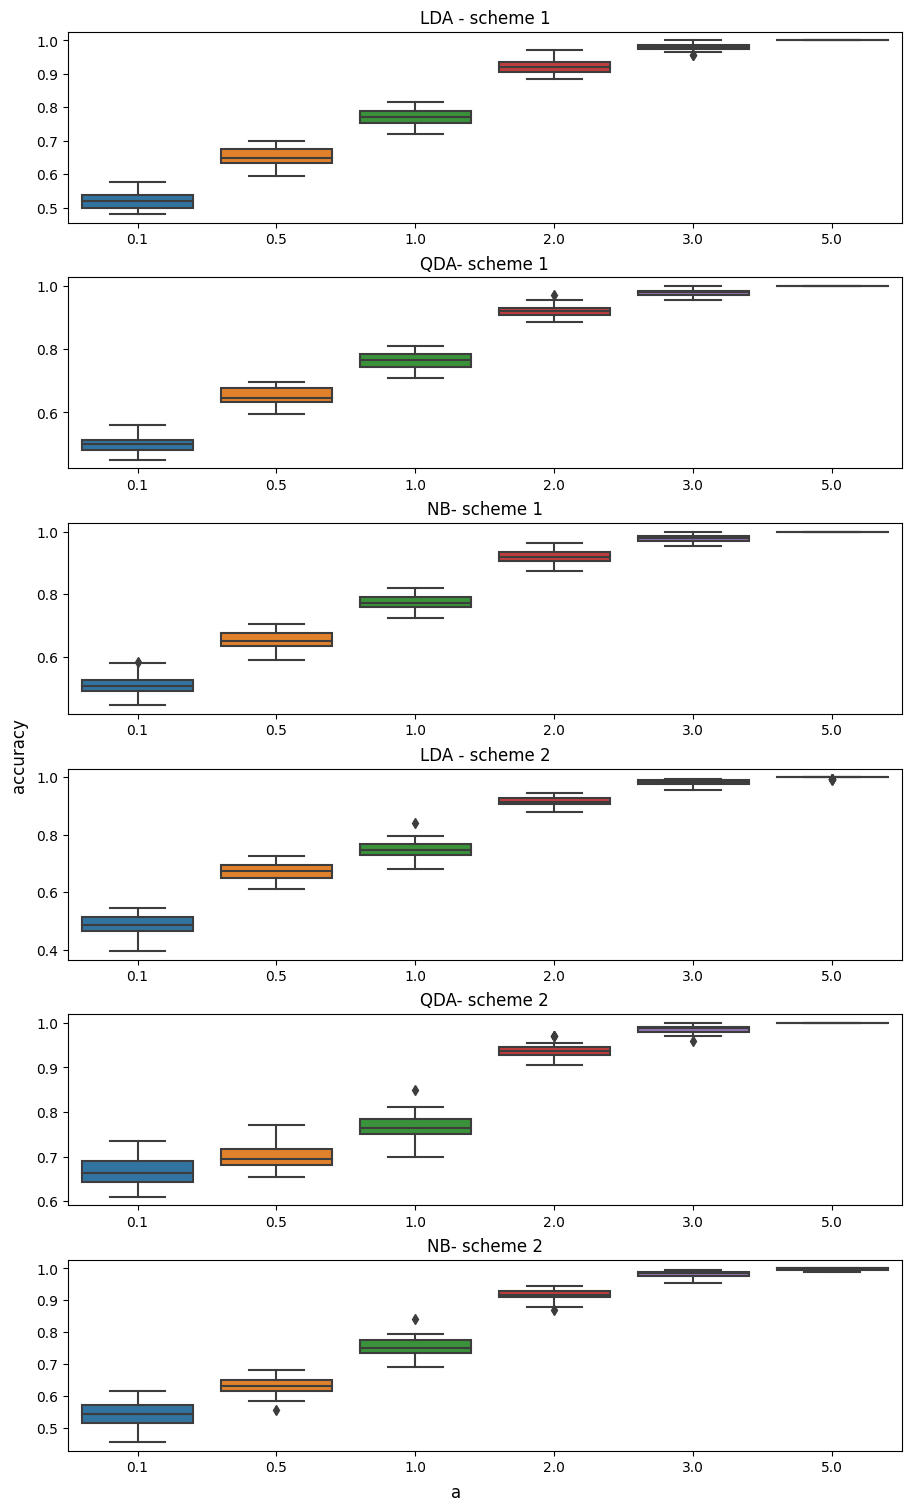

In [325]:
means = [0.1, 0.5, 1, 2, 3, 5]
corrs = 0.5

iter = 20

accuracies_1 = np.empty((3, len(means), iter * 2), dtype=float)
accuracies_2 = np.empty((3, len(means), iter * 2), dtype=float)

for m in range(len(means)):
    scheme1_X, scheme1_y = generate_schema_1(means[m])
    scheme2_X, scheme2_y = generate_schema_2(means[m], corrs)

    for i in range(iter * 2):
        X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(scheme1_X, scheme1_y, test_size=0.2)
        X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(scheme2_X, scheme2_y, test_size=0.2)

        lda.fit(X_train_1, y_train_1)
        qda.fit(X_train_1, y_train_1)
        nb.fit(X_train_1, y_train_1)

        accuracies_1[0, m, i] = accuracy_score(y_test_1, lda.predict(X_test_1))
        accuracies_1[1, m, i] = accuracy_score(y_test_1, qda.predict(X_test_1))
        accuracies_1[2, m, i] = accuracy_score(y_test_1, nb.predict(X_test_1))

        lda.fit(X_train_2, y_train_2)
        qda.fit(X_train_2, y_train_2)
        nb.fit(X_train_2, y_train_2)
        accuracies_2[0, m, i] = accuracy_score(y_test_2, lda.predict(X_test_2))
        accuracies_2[1, m, i] = accuracy_score(y_test_2, qda.predict(X_test_2))
        accuracies_2[2, m, i] = accuracy_score(y_test_2, nb.predict(X_test_2))

fig, axes = plt.subplots(6, 1, figsize=(9, 15), constrained_layout=True)

axes[0].set_title('LDA - scheme 1')
axes[1].set_title('QDA- scheme 1')
axes[2].set_title('NB- scheme 1')
axes[3].set_title('LDA - scheme 2')
axes[4].set_title('QDA- scheme 2')
axes[5].set_title('NB- scheme 2')

fig.supxlabel('a')
fig.supylabel('accuracy')

sns.boxplot(pd.DataFrame(accuracies_1[0].T, columns=[0.1, 0.5, 1, 2, 3, 5]), ax=axes[0])
sns.boxplot(pd.DataFrame(accuracies_1[1].T, columns=[0.1, 0.5, 1, 2, 3, 5]), ax=axes[1])
sns.boxplot(pd.DataFrame(accuracies_1[2].T, columns=[0.1, 0.5, 1, 2, 3, 5]), ax=axes[2])
sns.boxplot(pd.DataFrame(accuracies_2[0].T, columns=[0.1, 0.5, 1, 2, 3, 5]), ax=axes[3])
sns.boxplot(pd.DataFrame(accuracies_2[1].T, columns=[0.1, 0.5, 1, 2, 3, 5]), ax=axes[4])
sns.boxplot(pd.DataFrame(accuracies_2[2].T, columns=[0.1, 0.5, 1, 2, 3, 5]), ax=axes[5])

plt.savefig("BayesianSimulatedData1.pdf")

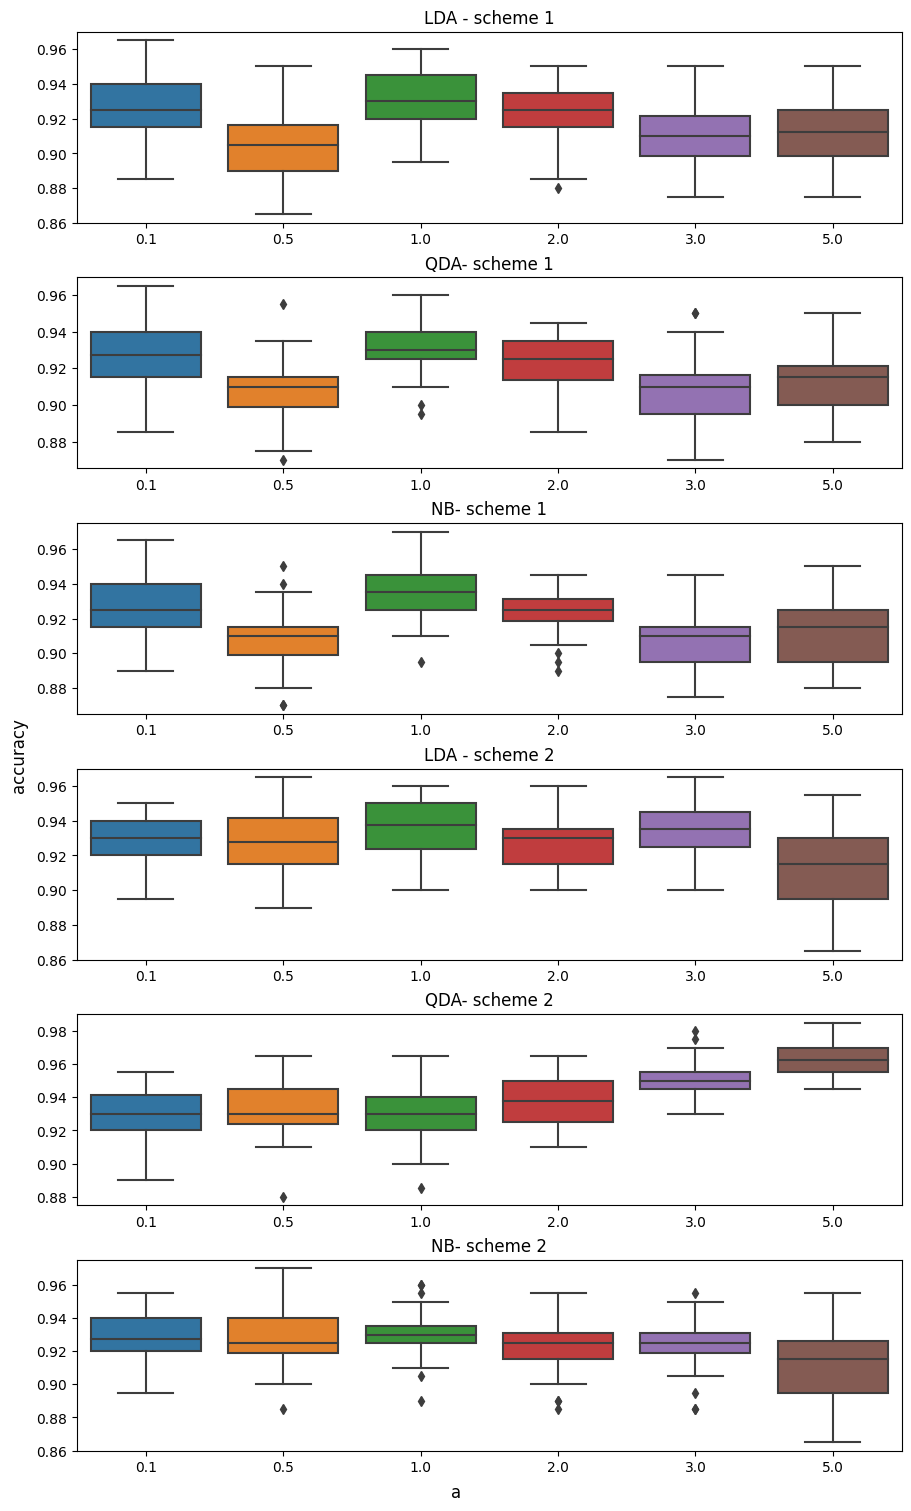

In [326]:
means = 2
corrs = [0, 0.1, 0.3, 0.5, 0.7, 0.9]

iter = 20

accuracies_1 = np.empty((3, len(corrs), iter * 2), dtype=float)
accuracies_2 = np.empty((3, len(corrs), iter * 2), dtype=float)


for r in range(len(corrs)):
    scheme1_X, scheme1_y = generate_schema_1(means)
    scheme2_X, scheme2_y = generate_schema_2(means, corrs[r])

    for i in range(iter * 2):
        X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(scheme1_X, scheme1_y, test_size=0.2)
        X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(scheme2_X, scheme2_y, test_size=0.2)

        lda.fit(X_train_1, y_train_1)
        qda.fit(X_train_1, y_train_1)
        nb.fit(X_train_1, y_train_1)
        accuracies_1[0, r, i] = accuracy_score(y_test_1, lda.predict(X_test_1))
        accuracies_1[1, r, i] = accuracy_score(y_test_1, qda.predict(X_test_1))
        accuracies_1[2, r, i] = accuracy_score(y_test_1, nb.predict(X_test_1))

        lda.fit(X_train_2, y_train_2)
        qda.fit(X_train_2, y_train_2)
        nb.fit(X_train_2, y_train_2)
        accuracies_2[0, r, i] = accuracy_score(y_test_2, lda.predict(X_test_2))
        accuracies_2[1, r, i] = accuracy_score(y_test_2, qda.predict(X_test_2))
        accuracies_2[2, r, i] = accuracy_score(y_test_2, nb.predict(X_test_2))

fig, axes = plt.subplots(6, 1, figsize=(9, 15), constrained_layout=True)

axes[0].set_title('LDA - scheme 1')
axes[1].set_title('QDA- scheme 1')
axes[2].set_title('NB- scheme 1')
axes[3].set_title('LDA - scheme 2')
axes[4].set_title('QDA- scheme 2')
axes[5].set_title('NB- scheme 2')

fig.supxlabel('a')
fig.supylabel('accuracy')

sns.boxplot(pd.DataFrame(accuracies_1[0].T, columns=[0.1, 0.5, 1, 2, 3, 5]), ax=axes[0])
sns.boxplot(pd.DataFrame(accuracies_1[1].T, columns=[0.1, 0.5, 1, 2, 3, 5]), ax=axes[1])
sns.boxplot(pd.DataFrame(accuracies_1[2].T, columns=[0.1, 0.5, 1, 2, 3, 5]), ax=axes[2])
sns.boxplot(pd.DataFrame(accuracies_2[0].T, columns=[0.1, 0.5, 1, 2, 3, 5]), ax=axes[3])
sns.boxplot(pd.DataFrame(accuracies_2[1].T, columns=[0.1, 0.5, 1, 2, 3, 5]), ax=axes[4])
sns.boxplot(pd.DataFrame(accuracies_2[2].T, columns=[0.1, 0.5, 1, 2, 3, 5]), ax=axes[5])

plt.savefig("BayesianSimulatedData2.pdf")

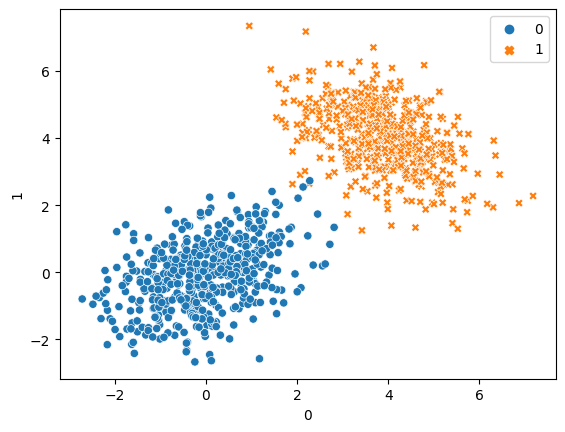

In [327]:
X, y = generate_schema_2(4, 0.4)

sns.scatterplot(data=pd.DataFrame(X), x=0, y=1, hue=y, style=y)

plt.savefig("BayesianSimulatedData3.pdf")

[Text(0.5, 1.0, 'Raisin dataset'),
 Text(0.5, 0, 'Method'),
 Text(0, 0.5, 'Accuracy')]

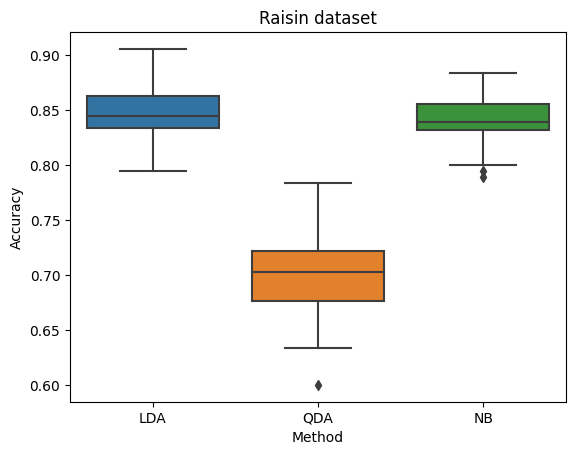

In [328]:
raisin_dataset = pd.read_csv("data/Raisin_Dataset.csv")
raisin_dataset.loc[raisin_dataset["Class"] == "Kecimen", "Class"] = 1
raisin_dataset.loc[raisin_dataset["Class"] == "Besni", "Class"] = 0
X = np.matrix(raisin_dataset.drop(columns=["Class"]))
y = np.array(raisin_dataset["Class"]).astype(int)

means = 3
corrs = 0.5
iter = 20

accuracies = np.empty((3, iter * 2), dtype=float)

for i in range(iter * 2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    lda.fit(X_train, y_train)
    qda.fit(X_train, y_train)
    nb.fit(X_train, y_train)

    accuracies[0, i] = accuracy_score(y_test, lda.predict(X_test))
    accuracies[1, i] = accuracy_score(y_test, qda.predict(X_test))
    accuracies[2, i] = accuracy_score(y_test, nb.predict(X_test))

sns.boxplot(pd.DataFrame(accuracies.T, columns=["LDA", "QDA", "NB"])).set(title="Raisin dataset", xlabel="Method", ylabel="Accuracy")

[Text(0.5, 1.0, 'Breast Cancer Coimbra'),
 Text(0.5, 0, 'Method'),
 Text(0, 0.5, 'Accuracy')]

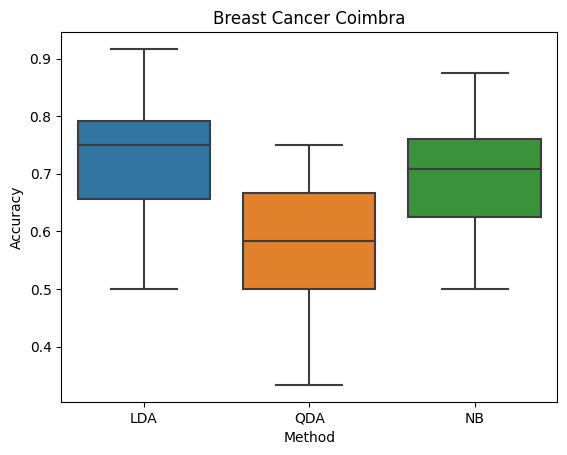

In [329]:
dataR2 = pd.read_csv("data/dataR2.csv")
dataR2.loc[dataR2["Classification"] == 1, "Classification"] = 0
dataR2.loc[dataR2["Classification"] == 2, "Classification"] = 1
X = np.matrix(dataR2.drop(columns=["Classification"]))
y = np.array(dataR2["Classification"]).astype(int)

means = 3
corrs = 0.5
iter = 20

accuracies = np.empty((3, iter * 2), dtype=float)

for i in range(iter * 2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    lda.fit(X_train, y_train)
    qda.fit(X_train, y_train)
    nb.fit(X_train, y_train)

    accuracies[0, i] = accuracy_score(y_test, lda.predict(X_test))
    accuracies[1, i] = accuracy_score(y_test, qda.predict(X_test))
    accuracies[2, i] = accuracy_score(y_test, nb.predict(X_test))

sns.boxplot(pd.DataFrame(accuracies.T, columns=["LDA", "QDA", "NB"])).set(title="Breast Cancer Coimbra", xlabel="Method", ylabel="Accuracy")

[Text(0.5, 1.0, 'Iris'), Text(0.5, 0, 'Method'), Text(0, 0.5, 'Accuracy')]

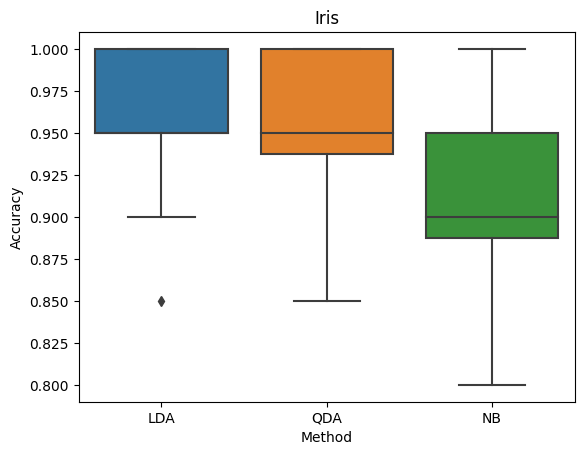

In [330]:
iris = pd.read_csv("data/iris.csv")
iris = iris[iris["variety"].isin(["Versicolor", "Virginica"])]
iris.loc[iris["variety"] == "Versicolor", "variety"] = 0
iris.loc[iris["variety"] == "Virginica", "variety"] = 1
X = np.matrix(iris.drop(columns=["variety"]))
y = np.array(iris["variety"]).astype(int)

means = 3
corrs = 0.5
iter = 20

accuracies = np.empty((3, iter * 2), dtype=float)

for i in range(iter * 2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    lda.fit(X_train, y_train)
    qda.fit(X_train, y_train)
    nb.fit(X_train, y_train)

    accuracies[0, i] = accuracy_score(y_test, lda.predict(X_test))
    accuracies[1, i] = accuracy_score(y_test, qda.predict(X_test))
    accuracies[2, i] = accuracy_score(y_test, nb.predict(X_test))

sns.boxplot(pd.DataFrame(accuracies.T, columns=["LDA", "QDA", "NB"])).set(title="Iris", xlabel="Method", ylabel="Accuracy")